# PyTorch Intro, CNN, Classification, Early stopping

In [102]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader
from IPython.display import clear_output

In [5]:
# git clone https://github.com/Bjarten/early-stopping-pytorch
# rename folder :)
from early_stopping_pytorch.pytorchtools import EarlyStopping

## Device check

In [11]:
import platform

In [12]:
platform.platform()

'macOS-13.0.1-arm64-arm-64bit'

In [15]:
torch.cuda.is_available()

False

In [16]:
torch.has_mps

True

In [17]:
torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device(type='cpu')

In [143]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')
device_cpu = torch.device('cpu')

## Dataset prepare
### Transformation pipline

In [19]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

### Dataset load

In [20]:
### Download dataset + apply transform
# https://pytorch.org/vision/stable/datasets.html
dataset = torchvision.datasets.CIFAR10("../data/",
                                       transform=data_transform,
                                       download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data/


In [26]:
type(dataset)

torchvision.datasets.cifar.CIFAR10

In [27]:
len(dataset)

50000

In [31]:
dataset.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [30]:
type(dataset.data)

numpy.ndarray

In [38]:
dataset.data.shape

(50000, 32, 32, 3)

In [34]:
dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

### Split dataset

In [65]:
SPLIT_RATIO = (0.4, 0.4, 0.2)
BATCH_SIZE = 32

In [66]:
train_samples = int(len(dataset) * SPLIT_RATIO[0])
valid_samples = int(len(dataset) *  SPLIT_RATIO[1])
test_samples = len(dataset) - train_samples - valid_samples # all remaining images
print("Train samples count: {}".format(train_samples))
print("Valid samples count: {}".format(valid_samples))
print("Test samples count: {}".format(test_samples))

Train samples count: 20000
Valid samples count: 20000
Test samples count: 10000


In [67]:
# return subsets of random images
train_ds, valid_ds, test_ds = torch.utils.data.random_split(dataset, (train_samples, valid_samples, test_samples))

### Create dataloader

In [87]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

## Model prepare

In [123]:
### Design model
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    # Define layers
    def __init__(self):
        super(Net, self).__init__()
        #how to calc input output -> how to calc feature matrix shape on the end layer
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 48, 3)
        self.conv3 = nn.Conv2d(48, 16*48, 3)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.4, inplace=False)

        self.fc1 = nn.Linear(768 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10) # Output shape 1x10 vector for 10 classes

    # Design model architecture from layers
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        # x = self.dropout1(x)
        x = self.pool(F.relu(self.conv3(x)))
        # x = self.dropout1(x)
        x = x.view(-1, 768 * 2 * 2) # flat

        x = F.relu(self.fc1(x))
        #batch_size x 1 x 128
        x = F.relu(self.fc2(x))
        #batch_size x 1 x 64
        x = F.relu(self.fc3(x))
        #batch_size x 1 x 32
        x = self.fc4(x)
        #batch_size x 1 x 10
        return x

### "Send model" to device

In [200]:
model = Net().to(device)

### Model lookup

In [201]:
# where is parameter of model located
next(model.parameters()).device

device(type='mps', index=0)

In [202]:
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(48, 768, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [199]:
from torchsummary import summary
summary(model.to(device_cpu), (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
         MaxPool2d-2           [-1, 16, 15, 15]               0
            Conv2d-3           [-1, 48, 13, 13]           6,960
         MaxPool2d-4             [-1, 48, 6, 6]               0
            Conv2d-5            [-1, 768, 4, 4]         332,544
         MaxPool2d-6            [-1, 768, 2, 2]               0
            Linear-7                  [-1, 128]         393,344
            Linear-8                   [-1, 64]           8,256
            Linear-9                   [-1, 32]           2,080
           Linear-10                   [-1, 10]             330
Total params: 743,962
Trainable params: 743,962
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.33
Params size (MB): 2.84
Estimated T

In [203]:
next(model.parameters()).device

device(type='mps', index=0)

## Train prepare
### Hyper-parameters

In [150]:
NUMBER_EPOCHS = 30
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 10

### Loss function

In [151]:
criterion = nn.CrossEntropyLoss()

### Metrics

In [152]:
# conda install -c conda-forge torchmetrics
from torchmetrics.classification import MulticlassAccuracy #not working on MPS :(
m_acc = MulticlassAccuracy(device=device_cpu, num_classes=10)

### Optimizer

In [153]:
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Early stopping

In [154]:
early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, verbose=True, path="net.pth")

## Train loop

In [156]:
# results aggregation - per epoch
avg_train_losses = []
avg_valid_losses = []

avg_train_m_acc = []
avg_valid_m_acc = []

for epoch in range(0, NUMBER_EPOCHS):
    clear_output(wait=True) # Jupyter notebook clearing

    # results aggregation - per iteration (number of iteration = dataset_size / batch_size
    train_losses = []
    valid_losses = []

    train_m_acc = []
    valid_m_acc = []

    # switch model to training mode -> for example: dropout is activated
    model.train()
    for input_data, classes in train_loader:
        # feed data to device
        data = input_data.to(device)
        target = classes.long().to(device)

        # clear gradient -> set gradiant to 0 -> null
        optimizer.zero_grad()
        # put train data to model -> inference
        output = model(data)
        # calc loss via loss function
        loss = criterion(output, target)
        # calc backward
        loss.backward()
        # update weights
        optimizer.step()
        # append train loss
        train_losses.append(loss.item())

        #My metrics
        train_m_acc.append(m_acc(output.to(device_cpu),target.to(device_cpu)))

    # switch model to eva state
    model.eval()
    # valid part
    for input_data, classes in valid_loader:
        # feed data to device
        data = input_data.to(device)
        target = classes.long().to(device)

        # put valid data to model -> inference
        output = model(data)
        # calc loss via loss function
        loss = criterion(output, target)
        # we don't need calc backward loss -> we don't update weights

        # append valid loss
        valid_losses.append(loss.item())

        #My metrics
        valid_m_acc.append(m_acc(output.to(device_cpu),target.to(device_cpu)))


    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    train_m_acc = np.average(train_m_acc)
    valid_m_acc = np.average(valid_m_acc)

    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    avg_train_m_acc.append(train_m_acc)
    avg_valid_m_acc.append(valid_m_acc)


    epoch_len = len(str(NUMBER_EPOCHS))

    print_msg = (f'[{epoch:>{epoch_len}}/{NUMBER_EPOCHS:>{epoch_len}}] ' +
                 f'train_loss: {train_loss:.5f} ' +
                 f'valid_loss: {valid_loss:.5f}')
    print(print_msg)



    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
    model.load_state_dict(torch.load("net.pth"))

[21/30] train_loss: 0.56586 valid_loss: 1.23380
EarlyStopping counter: 10 out of 10
Early stopping


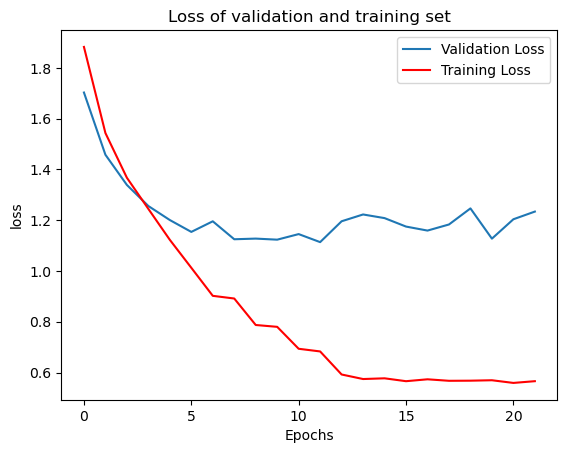

In [158]:
xx = np.arange(0,len(avg_valid_losses),1)
y_valid = np.array(avg_valid_losses)
y_train =  np.array(avg_train_losses)
plt.plot(xx, y_valid)
plt.plot(xx, y_train,color='red')
plt.legend(("Validation Loss","Training Loss"),labelcolor='black')
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Loss of validation and training set")
plt.show()

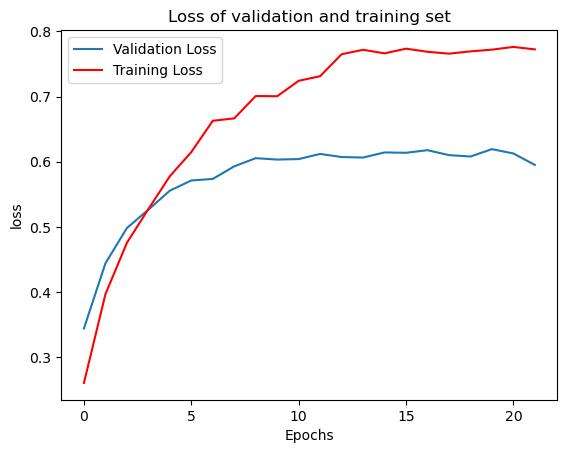

In [159]:
xx = np.arange(0,len(avg_valid_m_acc),1)
y_valid = np.array(avg_valid_m_acc)
y_train =  np.array(avg_train_m_acc)
plt.plot(xx, y_valid)
plt.plot(xx, y_train,color='red')
plt.legend(("Validation Loss","Training Loss"),labelcolor='black')
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Loss of validation and training set")
plt.show()

## Model evaluation

In [157]:
y_gts = np.array([])
y_preds = np.array([])
test_loss=[]
for input_data, classes in test_loader:

    # feed data to device
    x = input_data.to(device)
    y = classes.long().to(device)

    # create prediction
    y_pred = model(x)

    # calc loss function
    loss = criterion(y_pred, y)

    # calc predictions
    _, pred = torch.max(y_pred, 1)

    # get labels and predictions
    y_gts = np.hstack((y_gts, y.cpu().numpy()))
    y_preds = np.hstack((y_preds, pred.cpu().numpy()))

# Manual calculation of accuracy
print("Accuracy the NN is : {}".format(np.sum(y_gts==y_preds)/y_preds.shape[0]))

Accuracy the NN is : 0.6137


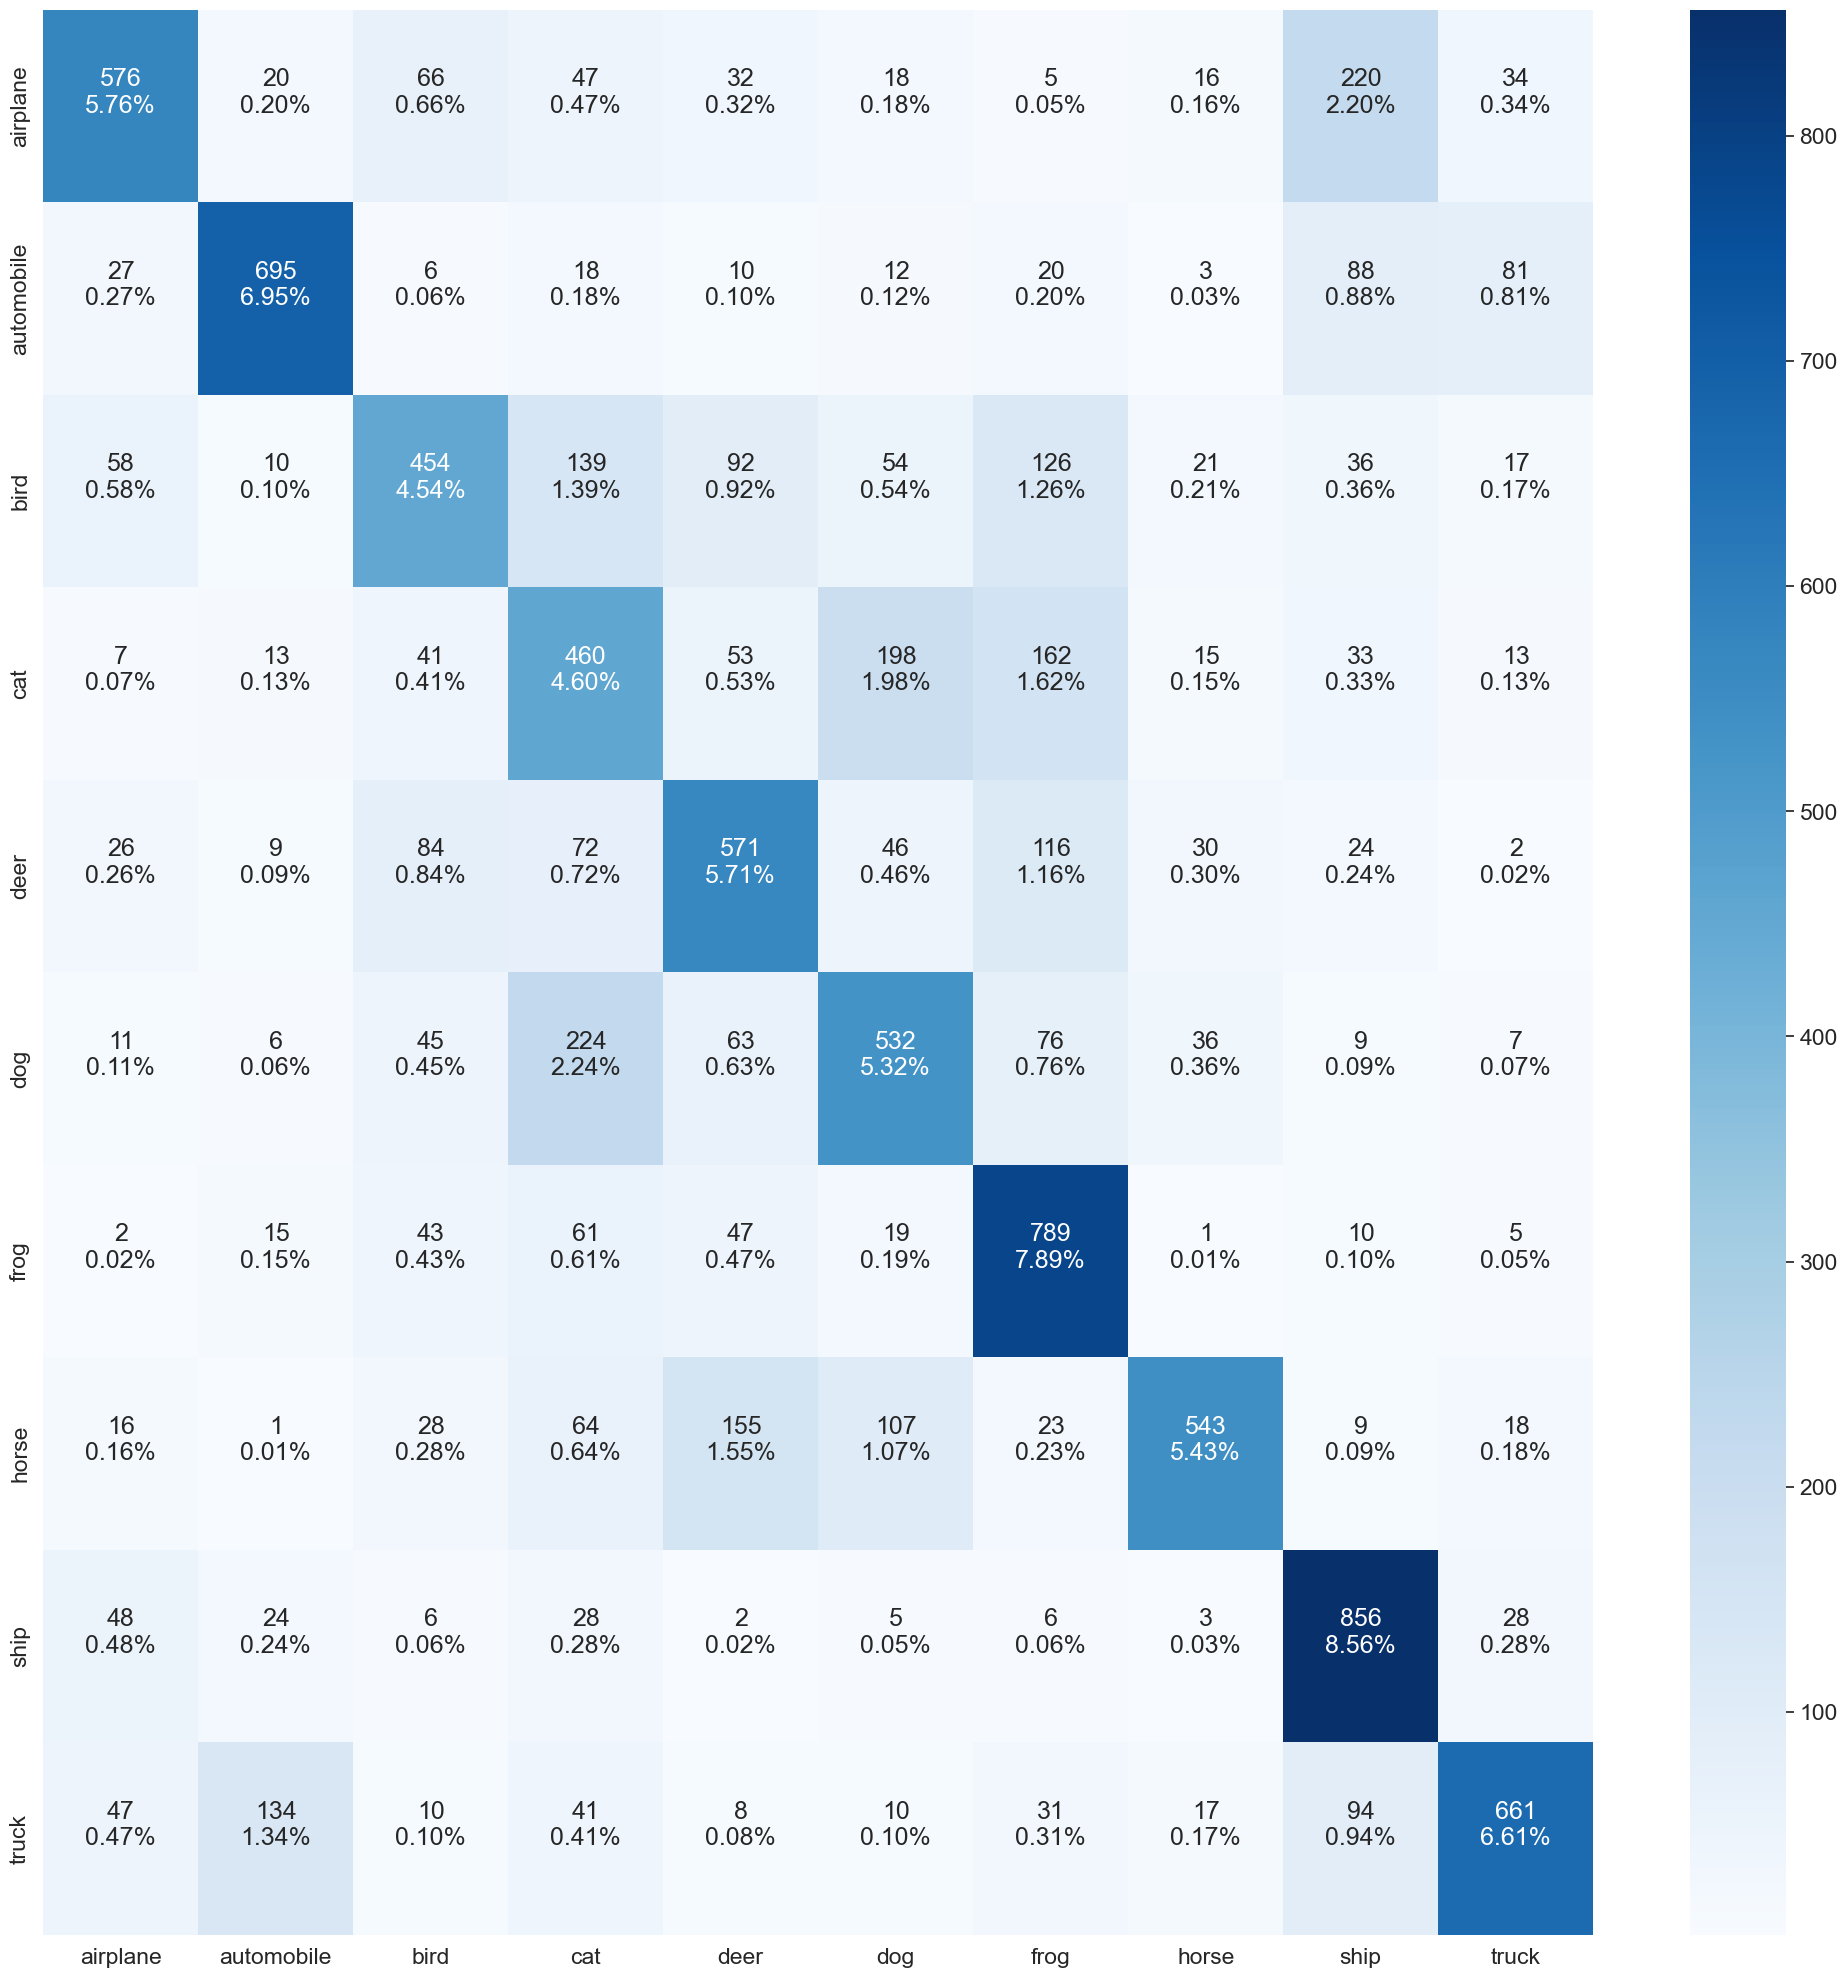

In [161]:
import seaborn as sn
import numpy as np
from sklearn.metrics import confusion_matrix

from sklearn import metrics

cm = confusion_matrix(y_gts,y_preds) #TP first
sn.set(font_scale=1.5) # for label size

plt.figure(figsize=(25,25))
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(10,10)

ax = sn.heatmap(cm,
                annot=labels,
                fmt="",
                cmap="Blues",xticklabels=dataset.classes, yticklabels=dataset.classes,)